### Data information

#### Name / Data Type / Measurement Unit / Description
-----------------------------
- Sex / nominal / -- / M, F, and I (infant)
- Length / continuous / mm / Longest shell measurement
- Diameter	/ continuous / mm / perpendicular to length
- Height / continuous / mm / with meat in shell
- Whole weight / continuous / grams / whole abalone
- Shucked weight / continuous	 / grams / weight of meat
- Viscera weight / continuous / grams / gut weight (after bleeding)
- Shell weight / continuous / grams / after being dried
- Rings / integer / -- / +1.5 gives the age in years

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling as yp
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D

from ydata_profiling import ProfileReport

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

C:\Users\lizob\anaconda3\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# import data set

datapath = 'Data/abalone.data'

data = pd.read_csv(datapath, header=None, index_col=False)
data.columns = [
    'sex', 'length', 'diameter', 'height', 'whole_weight',
    'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'
]

data.head()

sex  length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   shell_weight  rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

### Exploratory data analysis

In [3]:
profile = ProfileReport(data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

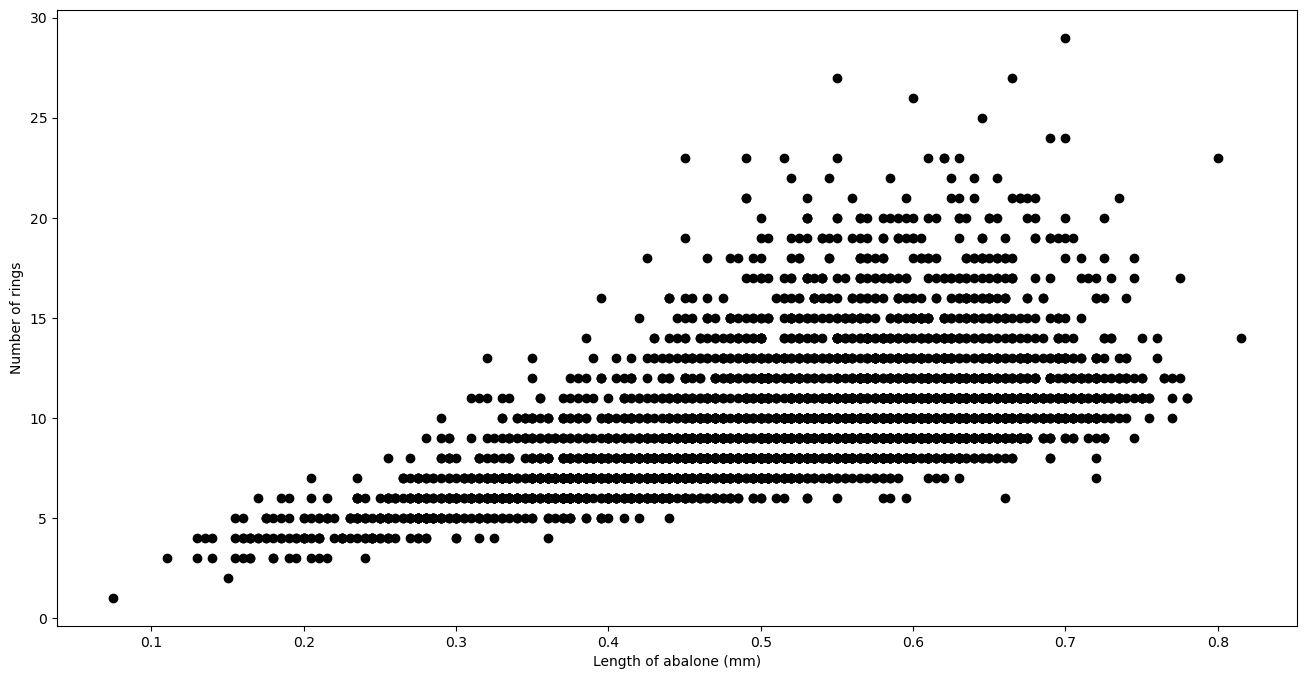

In [4]:
plt.figure(figsize=(16,8))
plt.scatter(data['length'], data['rings'], c='black')
plt.xlabel('Length of abalone (mm)')
plt.ylabel('Number of rings')
plt.show()

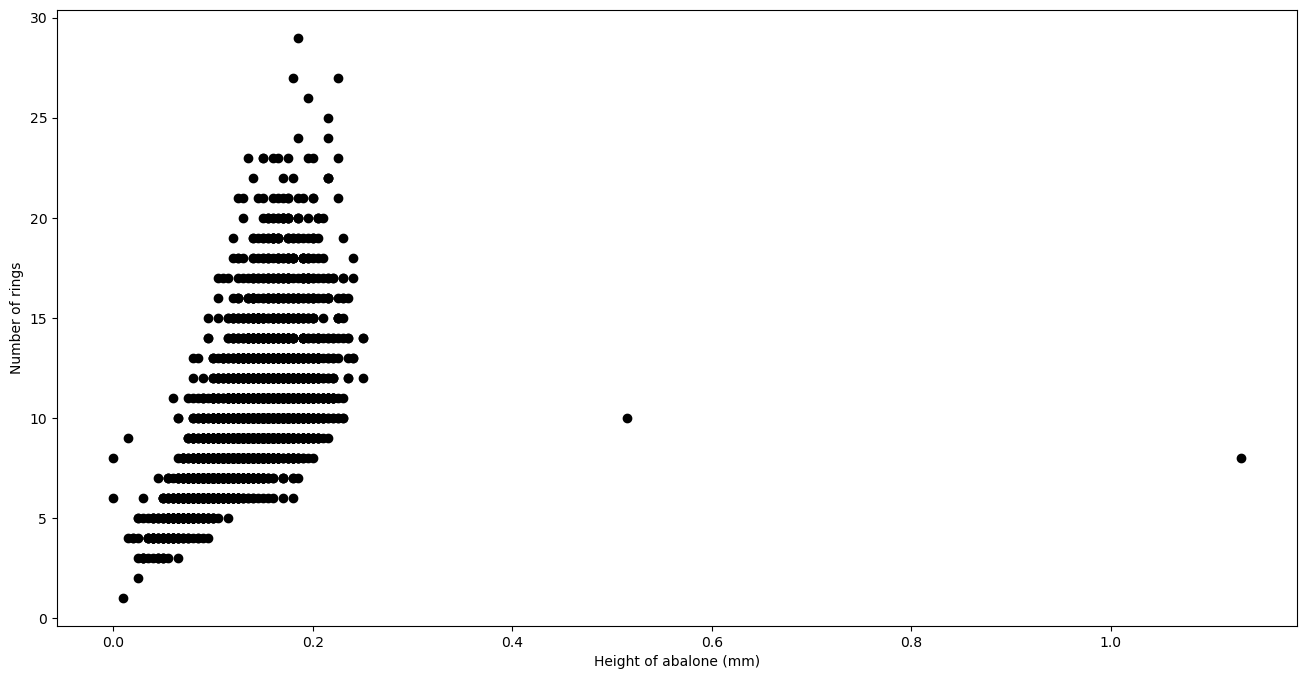

In [5]:
plt.figure(figsize=(16,8))
plt.scatter(data['height'], data['rings'], c='black')
plt.xlabel('Height of abalone (mm)')
plt.ylabel('Number of rings')
plt.show()

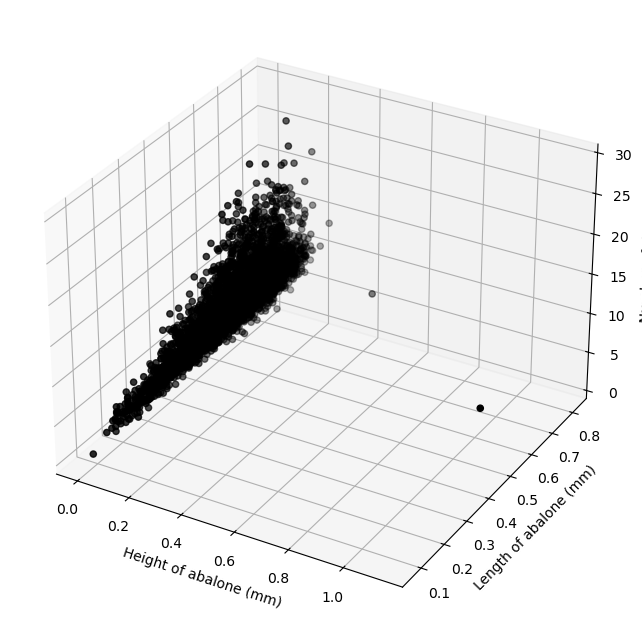

In [6]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection='3d')
ax.set_xlabel('Height of abalone (mm)')
ax.set_ylabel('Length of abalone (mm)')
ax.set_zlabel('Number of rings')
ax.scatter3D(data['height'], data['length'], data['rings'], c='black')
plt.show()

### Feature engineering
### One-hot encoding

In [6]:
encoded_data = pd.get_dummies(data, dtype=int)
encoded_data.head()

length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   shell_weight  rings  sex_F  sex_I  sex_M  
0         0.150     15      0      0      1  
1         0.070      7      0      0      1  
2         0.210      9      1      0      0  
3         0.155     10      0      0      1  
4         0.055      7      0      1      0

### Modeling
#### Split dataset

In [7]:
training_set = encoded_data.iloc[:4099,:]
validation_set= encoded_data.iloc[4099:, :]
print(training_set.shape)
print(validation_set.shape)

(4099, 11)
(78, 11)


#### Baseline model: multiple linear regression

In [9]:
x = training_set[['length', 'height']]
y = training_set['rings'].values.reshape(-1, 1)

x_val = validation_set[['length', 'height']]
y_val = validation_set['rings'].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [10]:
lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

# Test RMSE
lin_reg_pred = lin_reg.predict(x_test)
test_rmse = mean_squared_error(y_test, lin_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# Validation RMSE
lin_reg_pred_val = lin_reg.predict(x_val)
val_rmse = mean_squared_error(y_val, lin_reg_pred_val, squared=False)
print(f'Validation RMSE: {val_rmse}')

Test RMSE: 2.5679099174951547
Validation RMSE: 1.566178378231163


#### Multiple linear regression with regularization (ridge regression)

In [11]:
ridge = Ridge()

# cross validation to optimize the regularization parameter

parameters= {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# initialize grid search
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_root_mean_squared_error', cv=5)

# fit the model
ridge_regressor.fit(x_train, y_train);

print(ridge_regressor.best_params_)
print(-ridge_regressor.best_score_)

{'alpha': 1}
2.6564563658448885


In [12]:
# best parameter is alpha equal to 1
# use this parameter to retrain the model

ridge_reg = Ridge(alpha=1)
ridge_reg.fit(x_train, y_train)

ridge_reg_pred = ridge_reg.predict(x_test)

# test_rmse
test_rmse = mean_squared_error(y_test, ridge_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# validation RMSE
ridge_reg_pred_val = ridge_reg.predict(x_val)
val_rmse = mean_squared_error(y_val, ridge_reg_pred_val, squared=False)
print(f'Validation RMSE: {val_rmse}')


Test RMSE: 2.5871300097108296
Validation RMSE: 1.5640813253014871


#### Multiple linear regression with regularization (lasso)

In [13]:
lasso = Lasso(tol=0.05)

parameters= {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(x_train, y_train)

print(lasso_regressor.best_params_)
print(-lasso_regressor.best_score_)

{'alpha': 0.01}
7.130917624445476


In [14]:
# best alpha value is 0.01

lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(x_train, y_train)

lasso_reg_pred = lasso_reg.predict(x_test)

# test_rmse
test_rmse = mean_squared_error(y_test, lasso_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# validation RMSE
lasso_reg_pred_val = lasso_reg.predict(x_val)
val_rmse = mean_squared_error(y_val, lasso_reg_pred_val, squared=False)
print(f'Validation RMSE: {val_rmse}')

Test RMSE: 2.610473125813745
Validation RMSE: 1.5563831232308807


### Tree-based models

In [11]:
x = training_set.drop(['rings', 'diameter', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'], axis=1)

y = training_set['rings'].values.reshape(-1,1)

x_val = validation_set.drop(['rings', 'diameter', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'], axis=1)

y_val = validation_set ['rings'].values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)


#### Random forest


In [16]:
rf = RandomForestRegressor()

parameters = {'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)]}

rf_regressor = GridSearchCV(rf, parameters, scoring='neg_mean_squared_error', cv=5)

rf_regressor.fit(x_train, y_train.ravel())

print(rf_regressor.best_params_)
print(-rf_regressor.best_score_)

{'n_estimators': 600}
8.393881738248286


In [18]:
# optimal number of estimators is 600

rf_reg = RandomForestRegressor(n_estimators=600)
rf_reg.fit(x_train, y_train.ravel())

# Test RMSE
rf_reg_pred = rf_reg.predict (x_test)
test_rmse = mean_squared_error(y_test, rf_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# Validation RMSE
rf_reg_pred_val = rf_reg.predict(x_val)
val_rmse = mean_squared_error(y_val, rf_reg_pred_val, squared=False)

print(f'Validation RMSE: {val_rmse}')

Test RMSE: 2.6406174136892098
Validation RMSE: 2.236625236618618


### Light GBM

In [17]:
params = {
    'learning_rate': '0.01'
}

train_data = lgb.Dataset(x_train.values, label=y_train.ravel())


In [18]:
lgb_reg= lgb.train(params, train_data, 100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 3689, number of used features: 5
[LightGBM] [Info] Start training from score 9.955001


In [19]:
lgb_reg_pred = lgb_reg.predict(x_test)

# Test RMSE
test_rmse = mean_squared_error(y_test, lgb_reg_pred, squared=False)
print(f'Test: RMSE: {test_rmse}')

# Validation RMSE
lgb_reg_pred_val = lgb_reg.predict(x_val)
val_rmse = mean_squared_error(y_val, lgb_reg_pred_val, squared=False)
print(f'Validation RMSE: {val_rmse}')

Test: RMSE: 2.5516374432050553
Validation RMSE: 1.5097310114966809


### Compile Results

In [21]:
rmse_compilation = {
    'model': ['linear regression', 'ridge regression', 'lasso', 'random forest', 'LightGBM'],
    'RMSE': [1.5662, 1.5641, 1.5563, 2.2366, 1.5097]
}

rmse_df = pd.DataFrame(data=rmse_compilation)
rmse_df.sort_values(by=['RMSE'], ascending=True)

model    RMSE
4           LightGBM  1.5097
2              lasso  1.5563
1   ridge regression  1.5641
0  linear regression  1.5662
3      random forest  2.2366